In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random

from keras import layers
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras import models
from keras import optimizers
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import applications

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import glob
import os
from datetime import datetime

In [15]:
now = datetime.now()

#TRAIN_IMG_SRC_FOLDER = '/./lung-segmentation/uniq'
TRAIN_IMG_SRC_FOLDER = "lung-segmentation/uniq"
TRAIN_IMG_FOLDERS = {
    "p1": "healthy",
    "p2": "healthy",
    "p3": "healthy",
    "p4": "healthy",
    "p6": "others",
    "p7": "others",
    "p8": "others",
    "p9": "others",
    "p11": "covid",
    "p12": "covid",
    "p13": "covid",
    "p14": "covid",
    "p16": "covid",
    "p17": "covid",
    "p18": "covid",
    "p19": "covid",
    "p20": "covid"
}

VALIDATION_IMG_SRC_FOLDER = "lung-segmentation/uniq"
VALIDATION_IMG_FOLDERS = {
    "p5": "healthy",
    "p15": "covid",
    "p10": "others"
}

EXAM_SLICE = 200
CLASSES = len(set([label for label in TRAIN_IMG_FOLDERS.values()]))
EPOCHS = 10
width = 150
height = 150

In [16]:
dfs = []
train_images = {"id": [], "label": []}
validation_images = {"id": [], "label": []}

df_config = [
    (TRAIN_IMG_SRC_FOLDER, TRAIN_IMG_FOLDERS, train_images),
    (VALIDATION_IMG_SRC_FOLDER, VALIDATION_IMG_FOLDERS, validation_images)
]

def get_file_path(folder, search_filter=''):
    paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            if search_filter in path:
                paths.append(path)
    return paths

for (base, folder, dic) in df_config:
    for img_folder, img_label in folder.items():
        search_folder = "{}/{}".format(base, img_folder)
        imgs_filename = sorted(get_file_path(search_folder, search_filter = 'segmented'))
        imgs_filename = imgs_filename[(len(imgs_filename)-EXAM_SLICE)//2:(len(imgs_filename)+EXAM_SLICE)//2]
        dic["id"].extend(imgs_filename)
        dic["label"].extend([img_label] * len(imgs_filename))
        
    dfs.append(pd.DataFrame(data=dic))

train_df, validation_df = dfs[0], dfs[1]

train_df.to_csv('train_df.csv', index=False)
validation_df.to_csv('validation_df.csv', index=False)

print("Train fold with {} images".format(len(train_df)))
print(train_df.groupby("label").label.count())
print()
print("Validation fold with {} images".format(len(validation_df)))
print(validation_df.groupby("label").label.count())
print("-" * 30)

Train fold with 3400 images
label
covid      1800
healthy     800
others      800
Name: label, dtype: int64

Validation fold with 600 images
label
covid      200
healthy    200
others     200
Name: label, dtype: int64
------------------------------


Random Visualization of Training Data Samples

In [17]:
def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="all"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state = np.random.get_state()
    np.random.shuffle(train_images["id"])
    np.random.set_state(rng_state)
    np.random.shuffle(train_images["label"])
    for path, target in zip(train_images["id"], train_images["label"]):
        if target!=show and show!="all":
            continue
        counter=counter+1
        if counter%100==0:
            break
        #Image loading from disk as JpegImageFile file format
        img=load_img(path, target_size=(width,height))
        #Converting JpegImageFile to numpy array
        img=img_to_array(img)
        
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title = {"all":"All Classifications's",
             "healthy":"Healthy",
             "covid":"Covid-19"}
    plt.title("100 Samples of {} Patients of the training set".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))

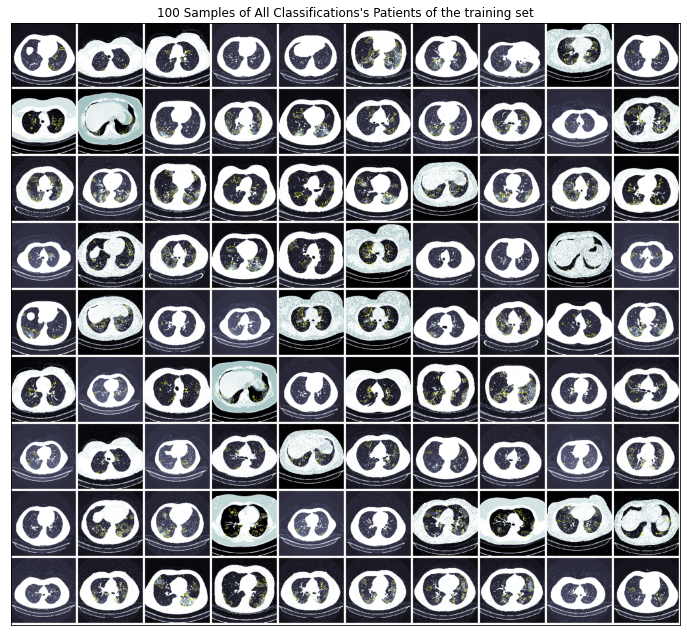

In [18]:
show_gallery("all")

Data Generator

In [19]:
def get_data_generator(dataframe, x_col, y_col, subset=None, shuffle=True, batch_size=32, class_mode="binary"):
    datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1)
    
    data_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col=x_col,
        y_col=y_col,
        subset=subset,
        target_size=(width, height),
        class_mode=class_mode,
        # color_mode="rgb",
        batch_size=batch_size,
        shuffle=shuffle,
    )
    return data_generator

See sample generated images

Found 1 validated image filenames belonging to 1 classes.


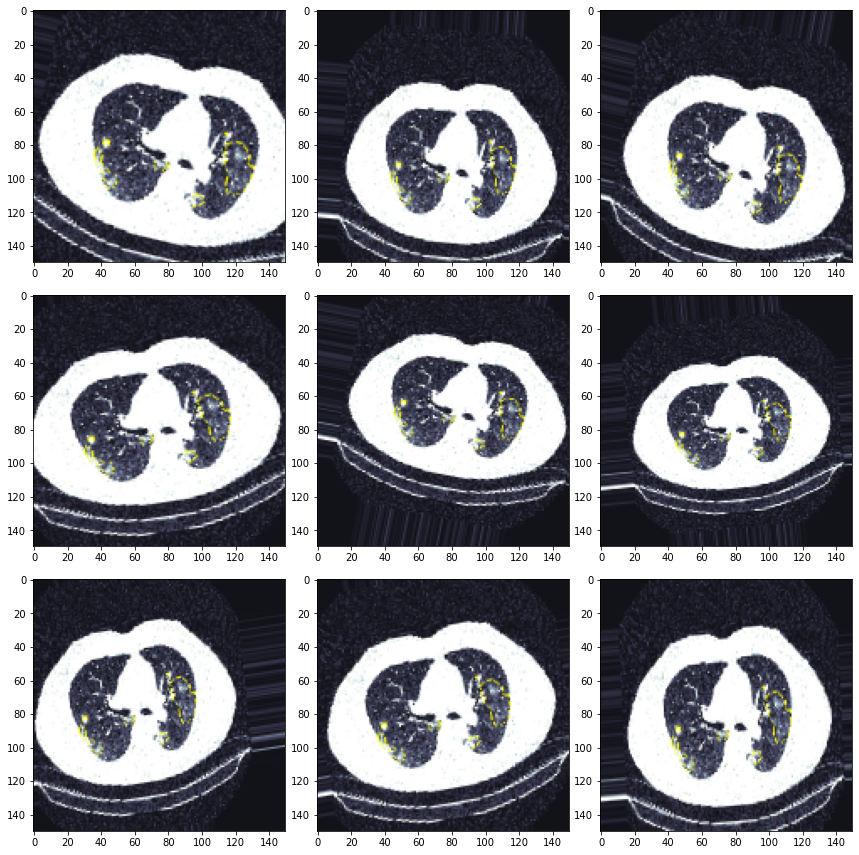

In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = get_data_generator(example_df, "id", "label", class_mode = "categorical")

plt.figure(figsize = (12,12))
for i in range(0, 9):
        plt.subplot(3, 3, i+1)
        for X_batch, Y_batch in example_generator:
            image = X_batch[0]
            plt.imshow(image)
            break
plt.tight_layout()
plt.show()

Building model from scratch

In [21]:
def get_model():
    classifier= Sequential()

    classifier.add(Convolution2D(32, (3, 3), input_shape=(height, width, 3), activation= 'relu'))
    classifier.add(MaxPooling2D(pool_size= (2,2)))

    classifier.add(Convolution2D(64, (3, 3), activation= 'relu'))
    classifier.add(MaxPooling2D(pool_size= (2,2)))

    classifier.add(Convolution2D(128, (3, 3), activation= 'relu'))
    classifier.add(MaxPooling2D(pool_size= (2,2)))

    classifier.add(Convolution2D(128, (3, 3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size= (2,2)))
    
    classifier.add(Convolution2D(256, (3,3), activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size= (2,2)))
    
    #classifier.add(Convolution2D(256, (3,3), activation = 'relu'))
    #classifier.add(MaxPooling2D(pool_size= (2,2)))

    classifier.add(Flatten())

    classifier.add(Dense(units= 512, activation= 'relu'))
    #classifier.add(Dense(units= 128, activation= 'relu'))
    classifier.add(Dropout(0.2))
    #classifier.add(Dense(units= 128, activation= 'relu'))
    #classifier.add(Dropout(0.1))
    classifier.add(Dense(units= 3, activation= 'sigmoid'))

    classifier.compile(optimizer= 'adam', loss= 'categorical_crossentropy' ,metrics= ['accuracy'])
    classifier.summary()

    return classifier

In [22]:
def train_model(model, train_df, validation_df, epochs, callbacks=[]):
    batch_size = 16
    train_generator = get_data_generator(train_df, "id", "label", batch_size=batch_size, class_mode="categorical")
    validation_generator = get_data_generator(validation_df, "id", "label", batch_size=batch_size, class_mode="categorical")

    step_size_train = train_generator.n // train_generator.batch_size
    step_size_validation = validation_generator.n // validation_generator.batch_size

    if step_size_train == 0:
        step_size_train = train_generator.n // 2
        step_size_validation = validation_generator.n // 2

    history = model.fit(
        train_generator,
        steps_per_epoch=step_size_train,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=step_size_validation,
        callbacks=callbacks
    )

    return history.history

In [23]:
def plot_results(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

Fitting and Visualizing Results

In [24]:
model = get_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

In [25]:
history = train_model(model, train_df, validation_df, EPOCHS)

Found 3400 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.
Epoch 1/10
212/212 [==============================] - 39s 182ms/step - loss: 0.8699 - accuracy: 0.6011 - val_loss: 0.8374 - val_accuracy: 0.6098
Epoch 2/10
212/212 [==============================] - 38s 178ms/step - loss: 0.5995 - accuracy: 0.7503 - val_loss: 0.6393 - val_accuracy: 0.7213
Epoch 3/10
212/212 [==============================] - 38s 180ms/step - loss: 0.3521 - accuracy: 0.8682 - val_loss: 1.3279 - val_accuracy: 0.4916
Epoch 4/10
212/212 [==============================] - 38s 177ms/step - loss: 0.2248 - accuracy: 0.9229 - val_loss: 0.3628 - val_accuracy: 0.8514
Epoch 5/10
212/212 [==============================] - 38s 180ms/step - loss: 0.1188 - accuracy: 0.9563 - val_loss: 1.0479 - val_accuracy: 0.7213
Epoch 6/10
212/212 [==============================] - 39s 182ms/step - loss: 0.0964 - accuracy: 0.9666 - val_loss: 0.9321 - val_accuracy: 0.7635
Epoch 7/1

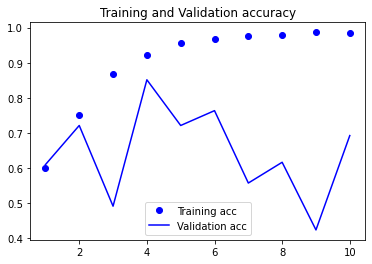

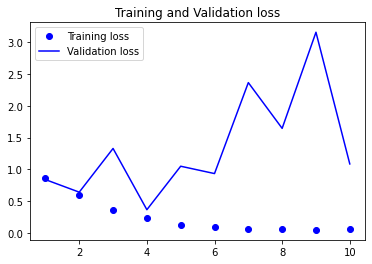

In [26]:
plot_results(history)